In [1]:
import json
import os
import math

import cv2
import pandas as pd
import numpy as np

from model.utils import (load_image, change_image_brightness, 
                         translate_image, bool_flip_image)

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Data exploration

In [2]:
# Loading CSV data to a pandas dataframe
print("Loading CSV file...")
df = pd.read_csv('data/driving_log.csv')
print("Size of the dataset: {}".format(df.shape))
df.head()

Loading CSV file...
Size of the dataset: (8036, 7)


center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  brake  \
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0   
1   IMG/right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0   
2   IMG/right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   
3   IMG/right_2016_12_01_13_31_13_037.jpg       0.0       0.0    0.0   
4   IMG/right_2016_12_01_13_31_13_177.jpg       0.0       0.0    0.0   

       speed  
0  22.148290  
1  21.879630  
2   1.453011  
3   1.438419  
4   1.418236

In [4]:
print("Some information about numeric fields (steering angle, throttle, brake, speed)...")
df.describe()

Some information about numeric fields (steering angle, throttle, brake, speed)...


steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360

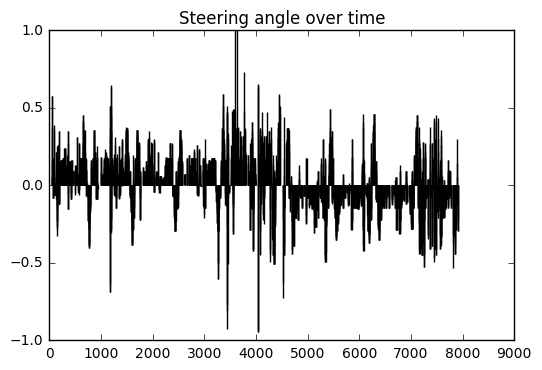

In [4]:
def plot_steering_angle_over_time(dataframe):
    plt.bar(dataframe.steering.index, df.steering.values, width=0.01)
    plt.title("Steering angle over time")
    plt.show()

plot_steering_angle_over_time(df)

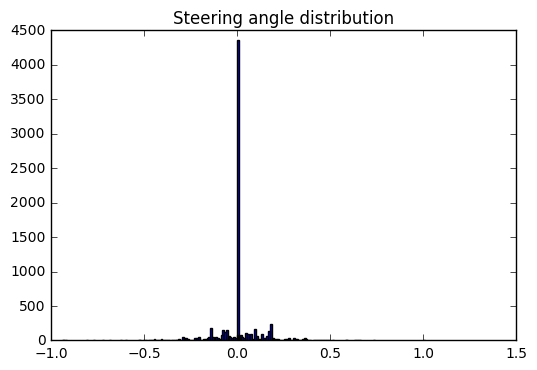

In [5]:
def plot_steering_angle_distribution(dataframe):
    hist = dataframe.steering.value_counts()
    plt.bar(hist.index, hist.values, width=0.01)
    plt.title("Steering angle distribution")
    plt.show()

plot_steering_angle_distribution(df)

Testing basic plotting functions...


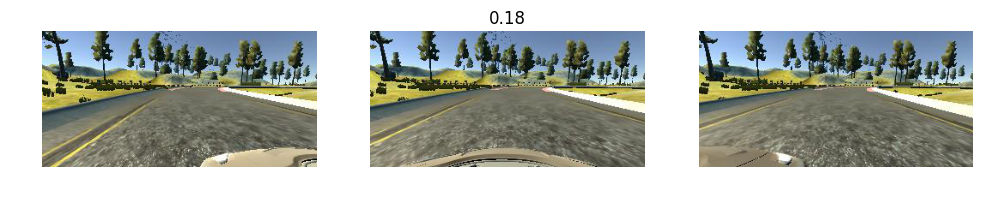

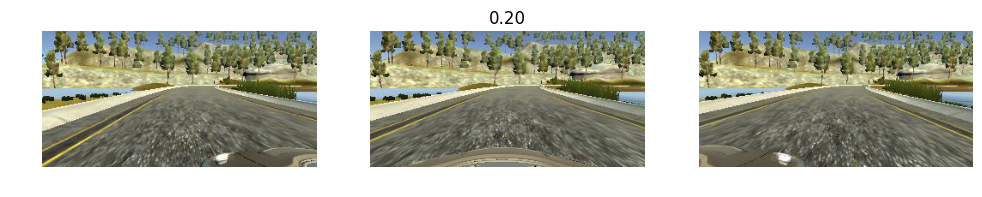

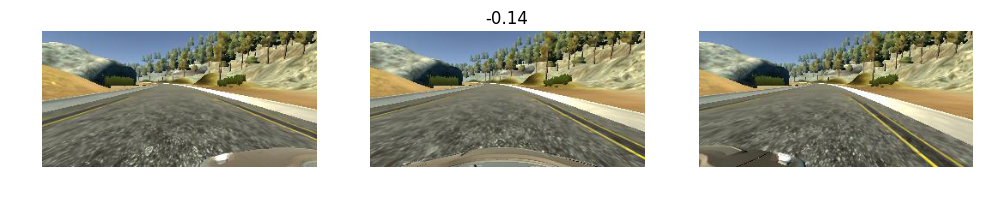

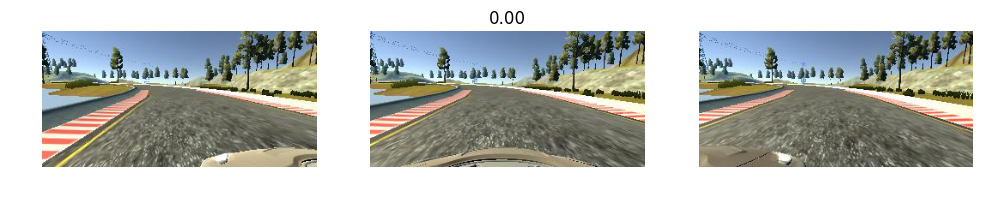

In [5]:
def get_images(img):
    img_c = load_image(img.center.strip())
    img_l = load_image(img.left.strip())
    img_r = load_image(img.right.strip())
    return img_l, img_c, img_r

def print_row(img_l, img_c, img_r, steering, plot_scale=1):
    plt.figure(figsize=(12 / plot_scale, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img_l);
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_c);
    plt.axis('off')
    plt.title('{:.2f}'.format(steering));

    plt.subplot(1, 3, 3)
    plt.imshow(img_r);
    plt.axis('off');

def test_basic_plot_functions(dataframe):
    print("Testing basic plotting functions...")
    rows = dataframe.sample(4)
    for index, row in rows.iterrows():
        img_l, img_c, img_r = get_images(row)
        print_row(img_l, img_c, img_r, row.steering)

test_basic_plot_functions(df)

# Testing augmentations

The following functions test and visualize the methods in model.utils

Testing brightness augmentation...


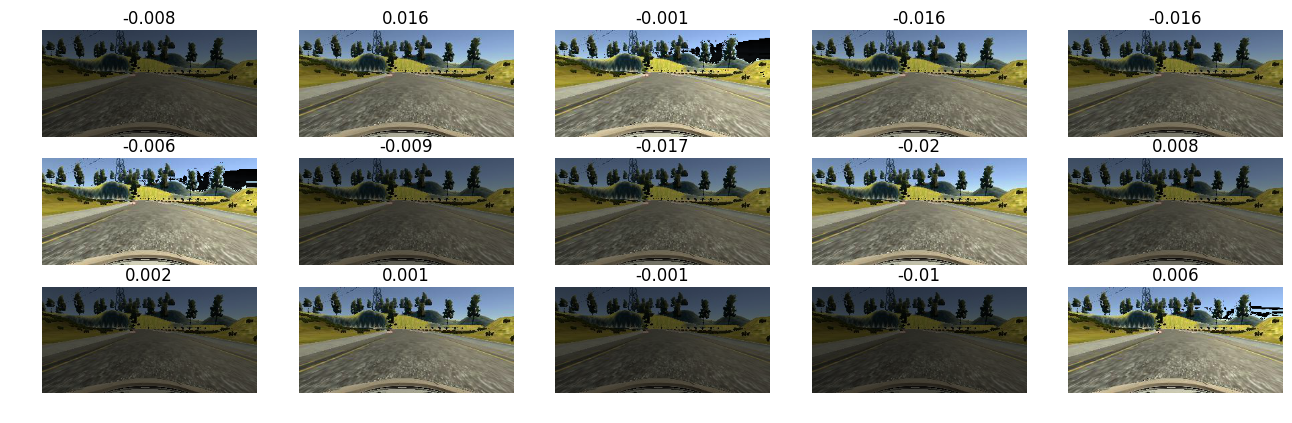

In [6]:
# Test Brightness augmentation
def test_change_image_brightness(dataframe):
    print("Testing brightness augmentation...")
    row = dataframe.sample().iloc[0]
    img_l, img_c, img_r = get_images(row)
    plt.figure(figsize=(16, 8))
    for idx in range(15):
        img, angle = change_image_brightness(img_c, row.steering)
        plt.subplot(5, 5, idx + 1)
        plt.title(np.round(angle, 3))
        plt.imshow(img)
        plt.axis('off')

test_change_image_brightness(df)

Testing image translation from a random original image...


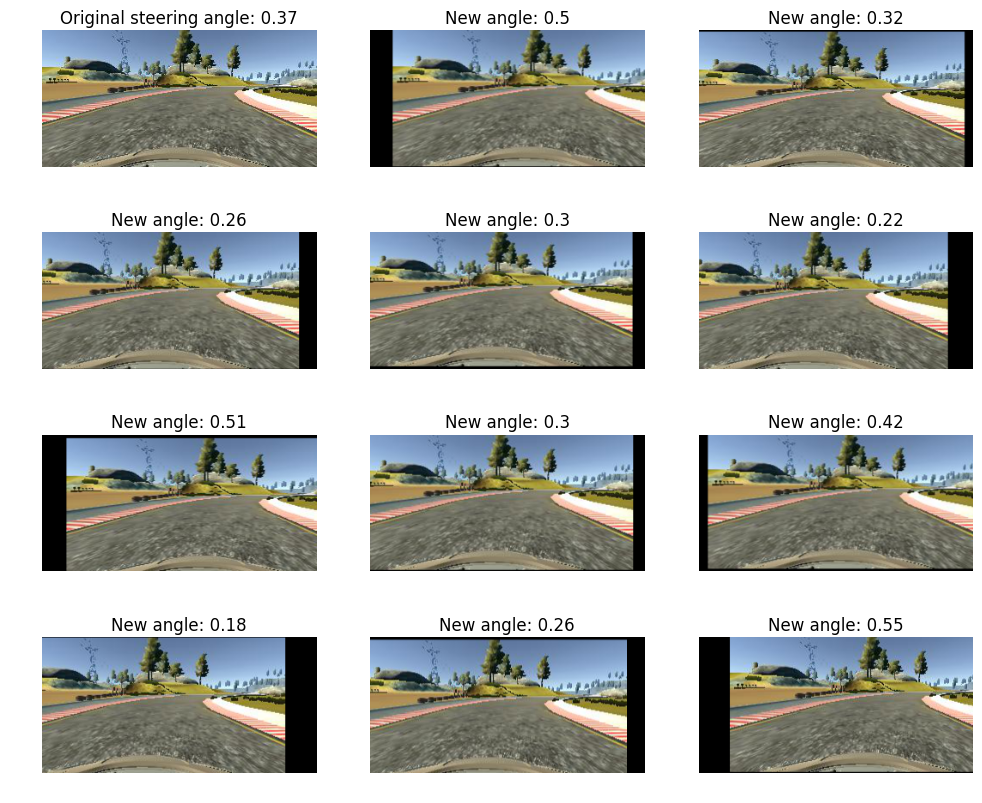

In [7]:
# Test Shift translation augmentation
def test_translate_image(dataframe):
    print("Testing image translation from a random original image...")
    row = dataframe[dataframe['steering'] > .1].sample().iloc[0]
    img_l, img_c, img_r = get_images(row)

    # Define the grid where the images are plotted
    plt.figure(figsize=(12, 10))

    # Plot the original image
    plt.subplot(4, 3, 1)
    plt.imshow(img_c)
    plt.title('Original steering angle: {}'.format(np.round(row.steering, 2)))
    plt.axis('off')

    # Generate 11 new images, applying translations to the original 
    # and plot in the grid
    for i in range(11):
        plt.subplot(4, 3, i+2)
        image_tr, angle = translate_image(img_c, row.steering, 80)
        plt.title('New angle: {}'.format(np.round(angle, 2)))
        plt.imshow(image_tr)
        plt.axis('off');

test_translate_image(df)

Testing the flipping augmentation with 4 random rows with angles different than 0...


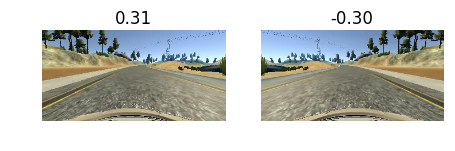

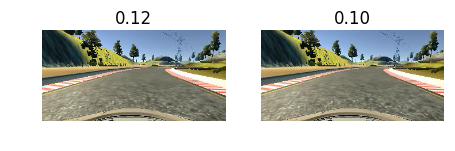

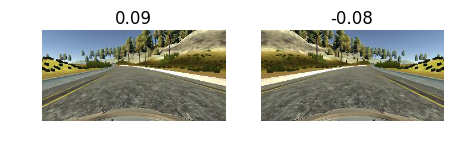

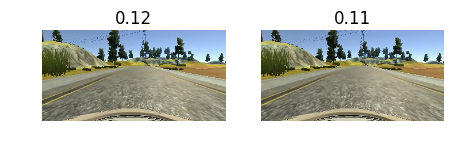

In [8]:
# Test Flipping the images horizontally augmentation: 
def test_bool_flip_image(dataframe):
    print("Testing the flipping augmentation with 4 random rows with angles different than 0...")
    rows = dataframe[dataframe['steering'] != 0].sample(4)
    for index, row in rows.iterrows():
        img_l, img_c, img_r = get_images(row)
        img_c2, steering2 = bool_flip_image(img_c, row.steering)

        plt.figure(figsize=(8, 2))

        plt.subplot(1, 3, 1)
        plt.imshow(img_c);
        plt.axis('off')
        plt.title('{:.2f}'.format(row.steering));

        plt.subplot(1, 3, 2)
        plt.imshow(img_c2);
        plt.axis('off')
        plt.title('{:.2f}'.format(steering2));
        
test_bool_flip_image(df)

In [9]:
def test_preprocess_image(model, dataframe):
    print("Testing the image preprocessing with 4 random images...")
    rows = dataframe.sample(3)
    for index, row in rows.iterrows():
        img_l, img_c, img_r = get_images(row)
        img_l = model.preprocess_image(img_l)
        img_c = model.preprocess_image(img_c)
        img_r = model.preprocess_image(img_r)
        print_row(img_l, img_c, img_r, row.steering)

Testing the image preprocessing with 4 random images...


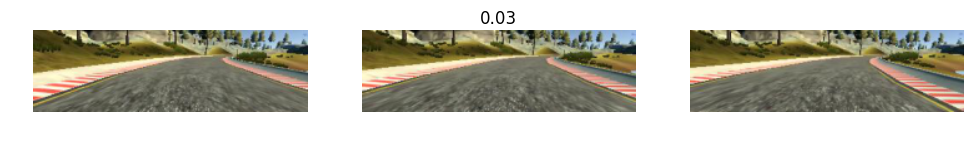

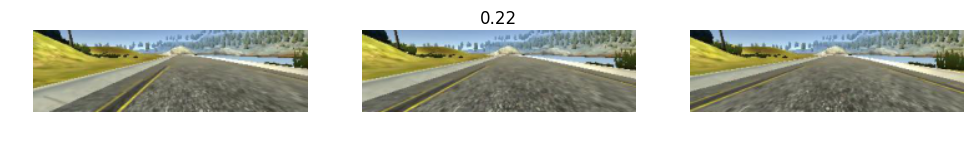

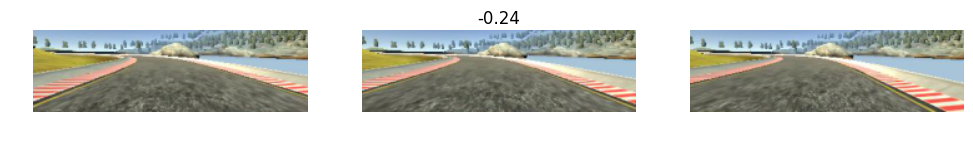

In [11]:
# Testing NVIDIA model image preprocessing
from model.nvidia import NvidiaModel
nvidia = NvidiaModel()        
test_preprocess_image(nvidia, df)

Testing the image preprocessing with 4 random images...


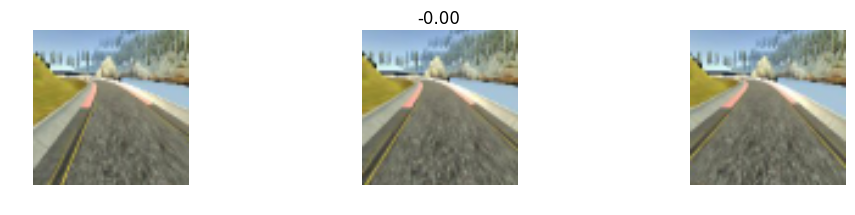

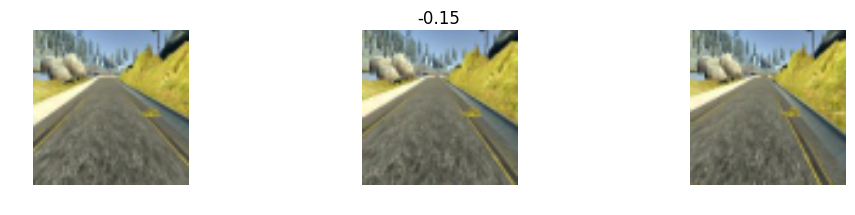

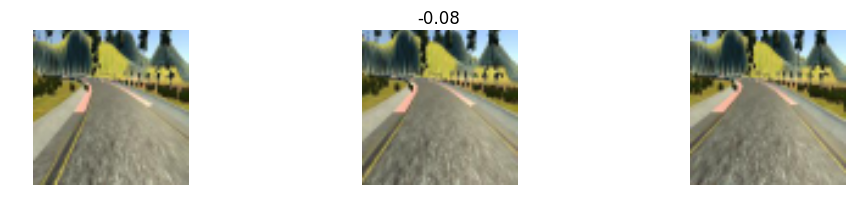

In [12]:
# Testing Custom model image preprocessing
from model.custom import CustomModel
custom = CustomModel()        
test_preprocess_image(custom, df)

In [23]:
def test_training_preprocess_image(model, dataframe):
    """
    Print the same image 16 times, using randomly augmentations
    """
    print("Testing the training image preprocessing...")
    row = dataframe.sample().iloc[0]
    plt.figure(figsize=(16, 10))
    for idx in range(12):
        img, steer = model.training_preprocess_image(row)
        plt.subplot(3, 4, idx + 1)
        plt.imshow(img);
        plt.axis('off')
        plt.title('{:.2f}'.format(steer));

Testing the training image preprocessing...


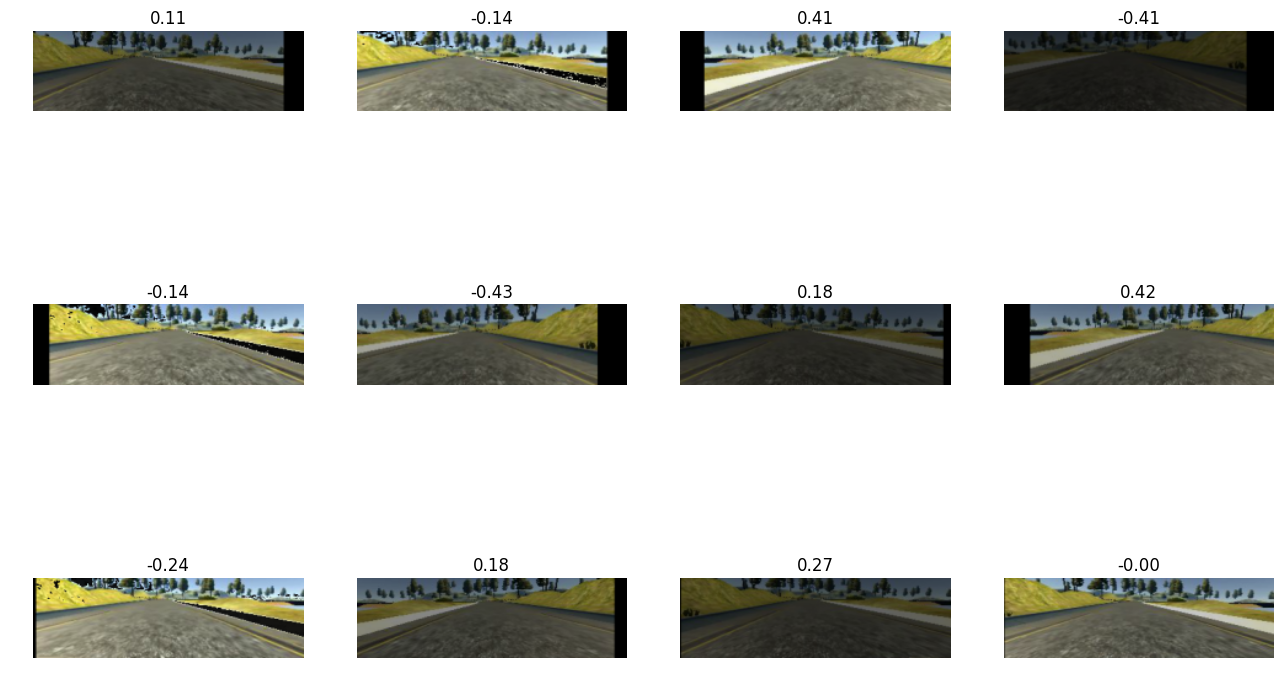

In [24]:
test_training_preprocess_image(nvidia, df)

Testing the training image preprocessing...


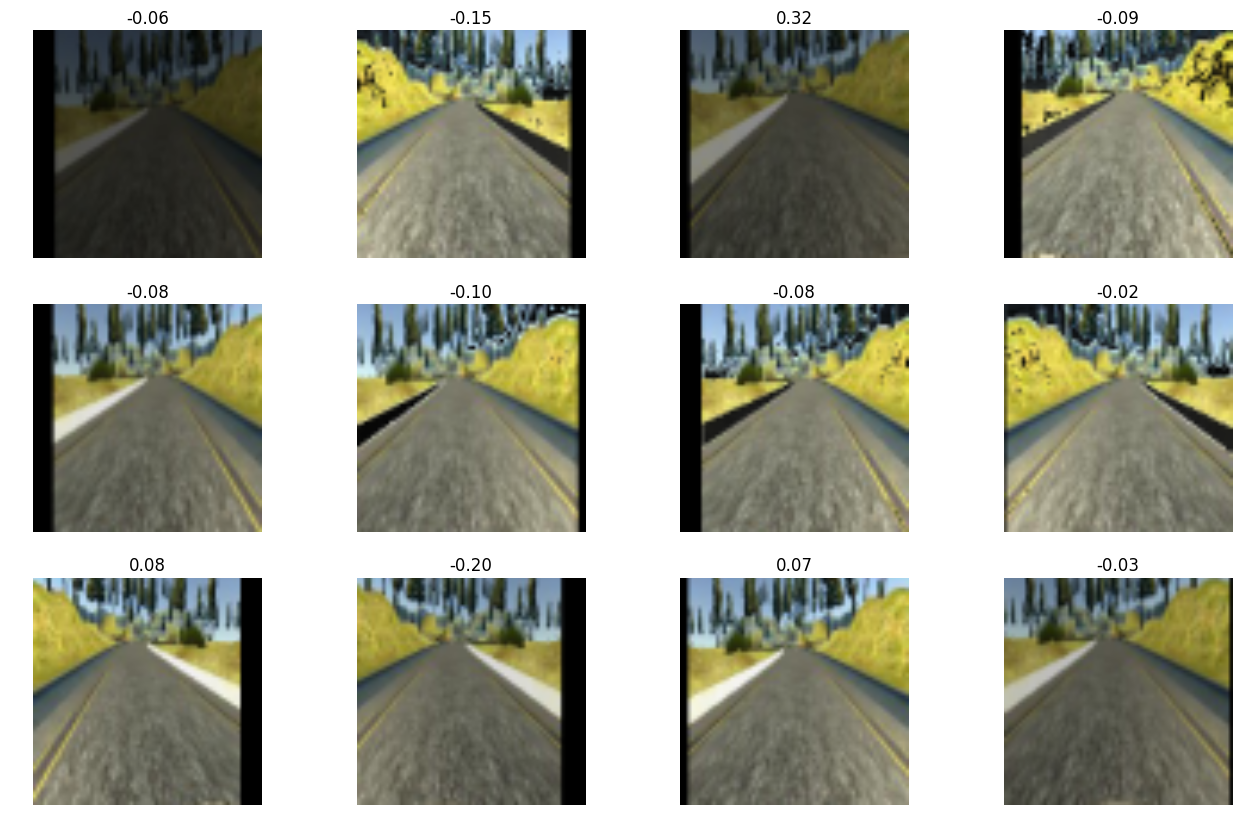

In [25]:
test_training_preprocess_image(custom, df)

In [26]:
def test_training_data_generator(model, dataframe):
    print("Testing the training data generator...")
    tdg = model.training_data_generator(dataframe, 16)
    for batch_idx in range(2):
        batch_images, batch_steering = next(tdg)
        print("   Generating batch #{}...".format(batch_idx))
        plt.figure(figsize=(16, 8))
        for i, img in enumerate(batch_images):
            plt.subplot(4, 8, i + 1)
            plt.imshow(img);
            plt.axis('off')
            plt.title('{:.2f}'.format(batch_steering[i]));

Testing the training data generator...
   Generating batch #0...
   Generating batch #1...


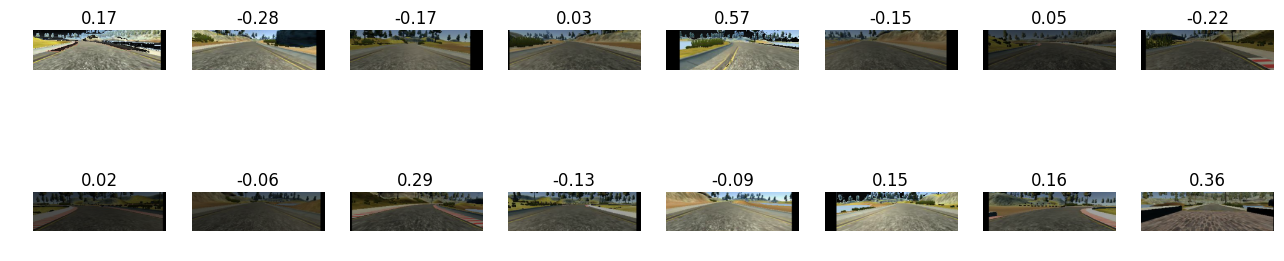

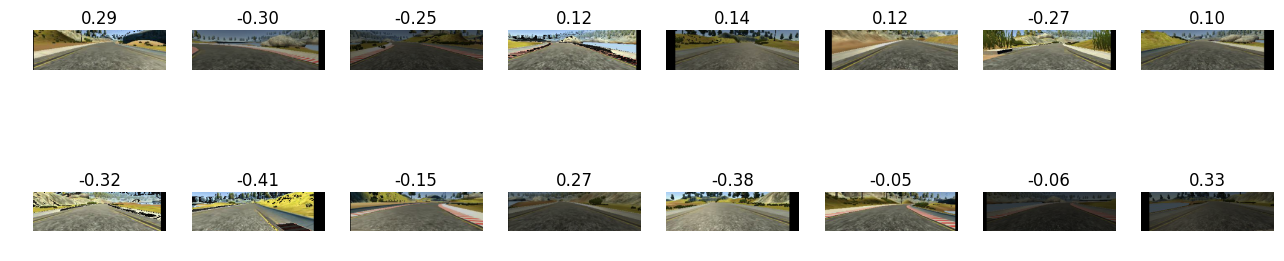

In [27]:
test_training_data_generator(nvidia, df)

Testing the training data generator...
   Generating batch #0...
   Generating batch #1...


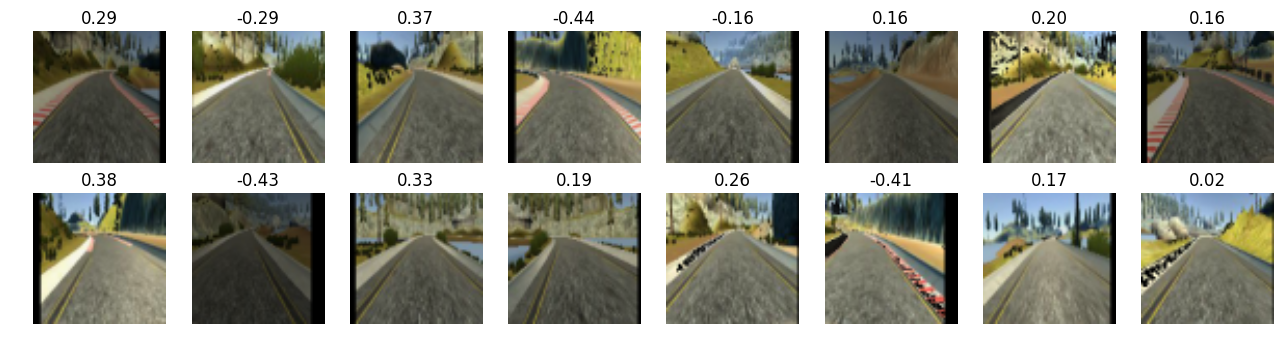

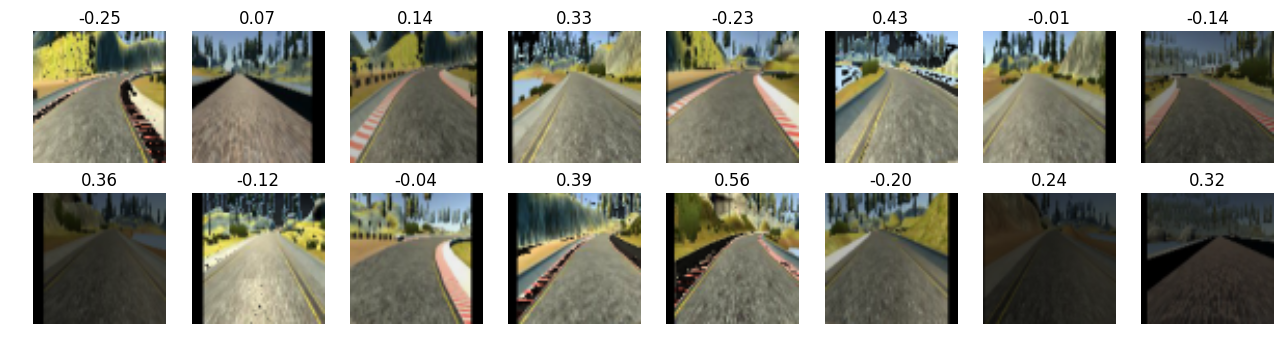

In [28]:
test_training_data_generator(custom, df)

In [29]:
def test_validation_preprocess_image(model, dataframe):
    print("Testing the validation image processing...")
    plt.figure(figsize=(16, 8))
    rows = dataframe.sample(4)
    idx = 0
    for index, row in rows.iterrows():
        img = model.validation_preprocess_image(row)
        plt.subplot(4, 8, idx+1)
        plt.imshow(img);
        plt.axis('off')
        plt.title('{:.2f}'.format(row.steering));
        idx += 1

Testing the validation image processing...


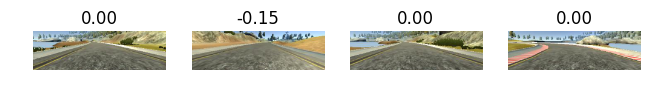

In [30]:
test_validation_preprocess_image(nvidia, df)

In [31]:
def test_validation_data_generator(model, dataframe):
    print("Testing the validation data generator...")
    print("")
    vdg = model.validation_data_generator(dataframe, 16)
    for batch_idx in range(2):
        batch_images, batch_steering = next(vdg)
        print("   Generating batch #{}...".format(batch_idx))
        plt.figure(figsize=(16, 8))
        for i, img in enumerate(batch_images):
            plt.subplot(4, 8, i + 1)
            plt.imshow(img);
            plt.axis('off')
            plt.title('{:.2f}'.format(batch_steering[i]));

Testing the validation data generator...

   Generating batch #0...
   Generating batch #1...


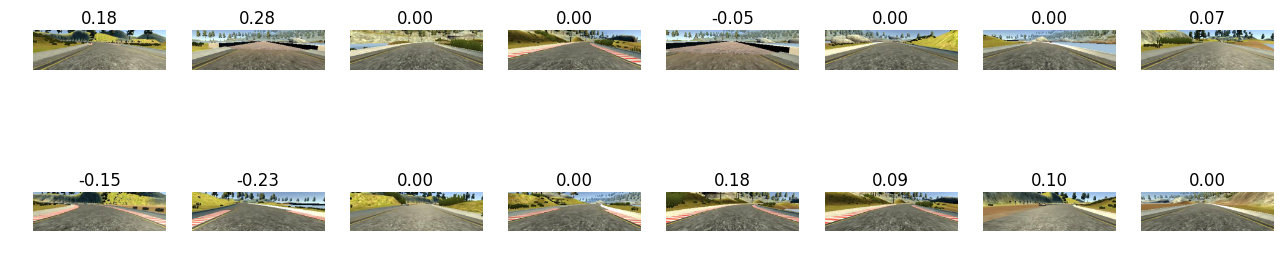

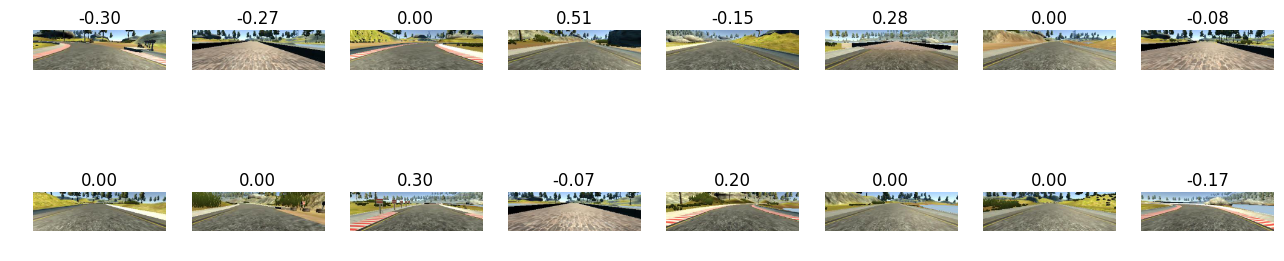

In [32]:
test_validation_data_generator(nvidia, df)

Testing the validation data generator...

   Generating batch #0...
   Generating batch #1...


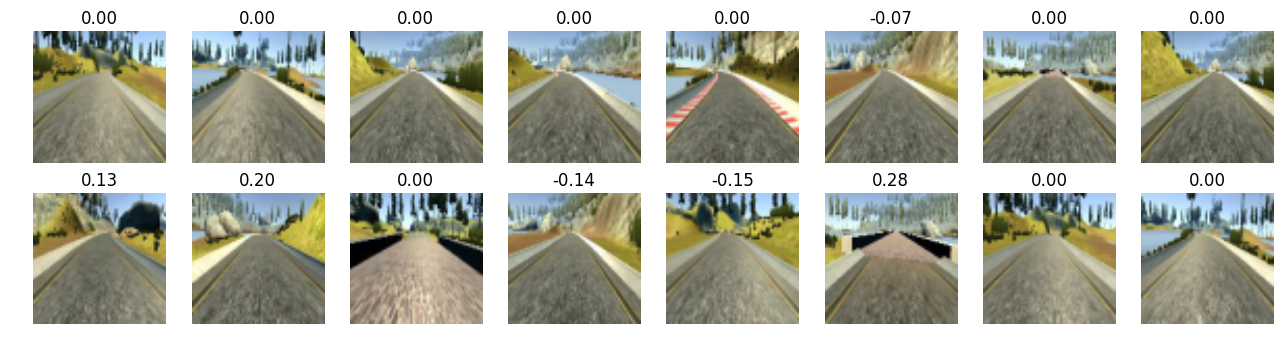

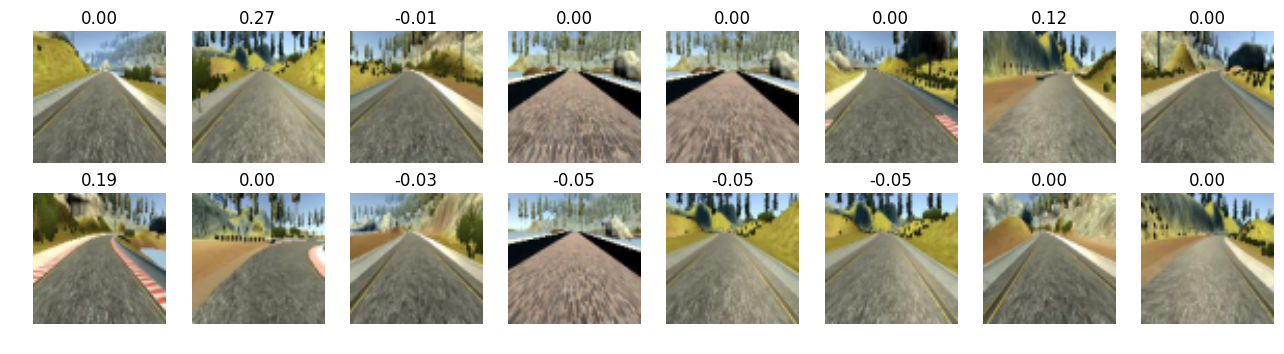

In [33]:
test_validation_data_generator(custom, df)

## Training the network


In [34]:
nvidia.train_model(epochs=1, batch_size=256)

v5
Training model:nvidia, image size(66, 220)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 220, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 108, 24)   1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 52, 36)    21636       convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 5, 24, 48)     43248       convolution2d_7[0][0]            
_____________________________________________

## Testing resu

In [36]:
from keras.models import Model, load_model
model = load_model('out/model_nvidia_00.h5')

ValueError: No model found in config file.

In [ ]:
def process_image(img_path):
    image = load_image(img_path)
    new_size = (220, 66)
    n_rows = image.shape[0]
    image = image[math.floor(n_rows / 5):n_rows - 25, :, :]
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return np.array(image)

X = np.asarray([process_image(row.strip()) for row in df['center']])
y = np.asarray(df['steering'])

In [ ]:
P = model.predict(X[:500])
#predict outputs nested arrays so we need to reshape to plot.
P = P.reshape((P.shape[0],)) 

pd.DataFrame({'predicted':P, 'actual':y[:500]}).plot()

In [ ]:
from model.carputer import CarputerModel
carputer = CarputerModel()        
carputer.train_model(epochs=5, batch_size=256)

In [ ]:
model = load_model('./out/model_carputer_03-0.02.h5')

In [ ]:
def process_image(model, img_path):
    image = load_image(img_path)
    new_size = (model.n_cols, model.n_rows)
    n_rows = image.shape[0]
    image = image[math.floor(n_rows / 5):n_rows - 25, :, :]
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return np.array(image)

X = np.asarray([process_image(carputer, row.strip()) for row in df['center']])
y = np.asarray(df['steering'])
P = model.predict(X[:500])
P = P.reshape((P.shape[0],)) 
pd.DataFrame({'predicted':P, 'actual':y[:500]}).plot();